# Description
- Author: Miguel Angel González Arias
- Date: December, 2024

This notebook is part of the selection process for the vacant as ["Deep Learning Scientist"](https://recruitment.crg.eu/content/jobs/position/researcher%E2%80%94computational-design-gene-editors-bioinformatician-0) at the Centre for Genomic Regulation in Barcelona, Spain. 

# 1. Introduction and results 

Protein language models (PLMs) are a type of deep learning algorithms that learns to encode proteins into a multidimensional vector space. How well this multidimensional space represents the protein biology depends on how proteins are encoded (e.g. as sequences, structures or time series), the architecture of the PLM, and the quantity, quality, and diversity of the training data.

The transformer architecture is a key component of PLMs. This architecture allows to learn local and long range dependencies through the use of attention heads across the layers of the model. These heads have been [demonstrated](https://www.biorxiv.org/content/10.1101/2020.12.15.422761v1) to be able to detect important residues for structure (e.g. contacts) and function (e.g. binding sites). Currently, almost all PLMs are based on the transformer architecture and use two main modeling strategies:
1. autoregressive: predict the most likely next amino acid given a chain of amino acids, which is useful for creating generative models.
2. autoencoding: predict the most likely amino acid in randomly masked regions of the sequence, which is useful for creating information-rich vector representations for downstream tasks.

Here I used two small autoencoding PLM to analyze the protein [ubiquitin](https://www.rcsb.org/structure/1YIW) (chain A; 71 residues) thougth the lens of attention by adapting the code from the paper ["BERTology Meets Biology"](https://github.com/salesforce/provis) and using ChatGPT. The PLM were:
- [TapeBERT](https://github.com/songlab-cal/tape): with 12 layers and 12 attention heads
- [ESM-2 8M](https://github.com/facebookresearch/esm): with 6 layers and 20 attention heads

## 1.1 TapeBERT

In "BERTology Meets Biology", the authors used a minimum attention threshold of 0.3 to select relevant pairs of residues. For those pairs of residues that did not pass the threshold, I assigned an attention value of zero. Then, I calculated the mean attention value using the detected pairs of residues in a particular layer and head. For example, in layer 7 and head 12, 65 pairs of residues were detected, and the average attention was 0.86.

The next heatmap shows the mean attention values for each layer and head of TapeBERT. To the right of the plot, the mean value for each layer is shown as bars. 

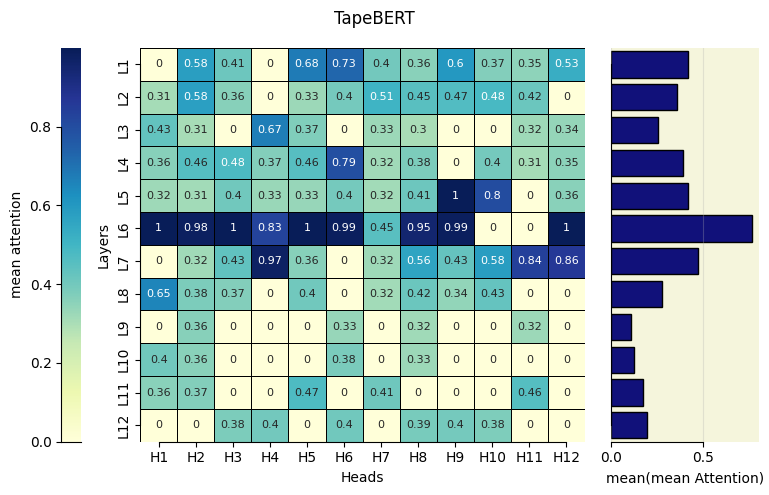

For ubiquitin, this analysis showed that the layer 6 has the highest attention values. After an inspection of the heads in this layer, it appears that the attention values are reflecting the sequential order of the backbone. For example, in the Layer 6 and Head 1 (i.e., L6-H1), the attention maps the residues Leu1 → Gln2 → Ile3 → Phe4, etc. The L6-H12 also maps the backbone sequentially, but with one residue interspaced (i.e., Leu1 → Ile3 → Val5 etc. and Gnl2 → Phe4 → Lys6, etc.). Additionally, L2-H2 maps various residues to Phe4, which was [previously reproted](https://pubmed.ncbi.nlm.nih.gov/11399765/) to be important for carrying out endocytosis. Finally L10-H1 was another example of a functional important residue detected with attention, in this case mapping various residues to Gly47, which has been suggested to play a role in the proteasome conjugation and degradation.

The next image shows all the above examples, indicating the layer and head, the mean attention value (attn), the number of residue pairs detected, and the true contacts derived from the structure.

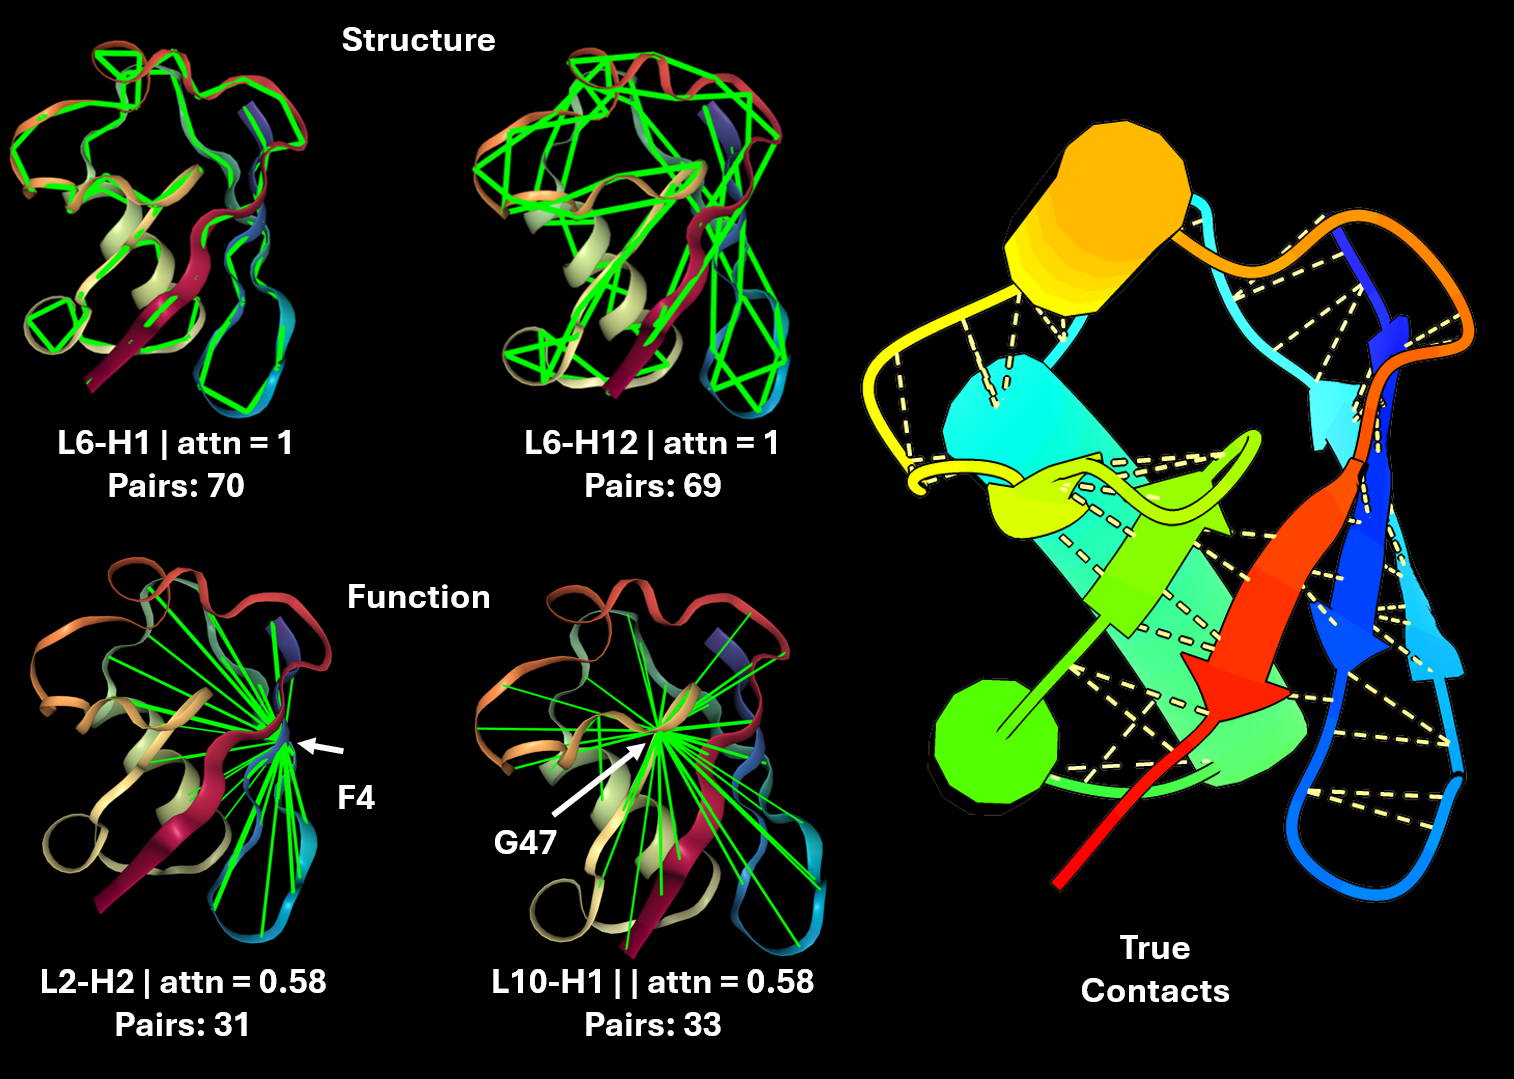

Then I tried to obtain the predicted contact maps by layer using the class [`PairwiseContactPredictionHead`](https://github.com/songlab-cal/tape/blob/6d345c2b2bbf52cd32cf179325c222afd92aec7e/tape/models/modeling_utils.py#L843). However I was unable to do this due to the lack of documentation. Because of this, I decided to use ESM-2 8M, which has better documentation. 

## ESM-2 8M

Using ESM-2 8M I calculated the mean attention value for each combination of layers and heads. Then, I applied min-max normalization across all values to scale them to a range between 0 and 1 to improving the visualization. Finally, I applied the same minimum attention threshold of 0.3 to select relevant residue pairs. The following heatmap displays the normalized attention values for each layer and head of ESM-2 8M. To the right of the plot, the mean value for each layer is shown as a bars.

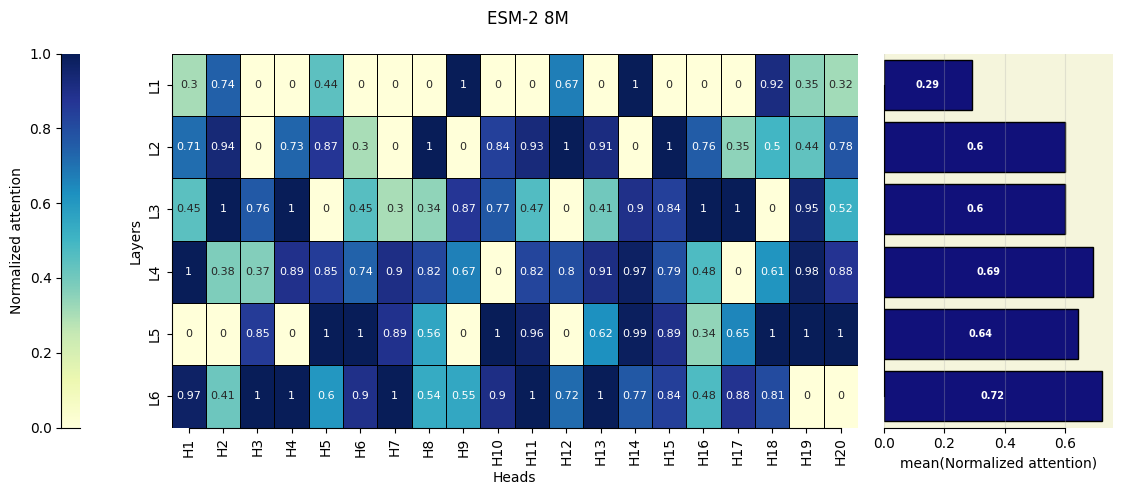

For ubiquitin, this analysis showed that layer 6 has the highest attention values. As a result, I calculated the contact maps for this layer and compared the predicted contacts by ESM2 8M against the true contacts of the protein. To obtain the true contacts, I used Graphein to build a graph from the PDB file and then determined the contact maps at a distance of 8 Å as a binary matrix. For the predicted contacts, I built a binary matrix by considering pairs with a probability value ≥ 0.3 as contacts.

The following image shows the true and predicted contacts as blue and orange circles, respectively. It can be seen that some long-distance contacts are correctly predicted by ESM2 8M, but there are also a few mistakes, possibly because it is a small model with just 8M parameters.

The logistic regression model trained to predict the contacts in the ESM family is unable to predict the local-range interactions, as [discussed here](https://github.com/facebookresearch/esm/discussions/72?sort=new#discussioncomment-698930).

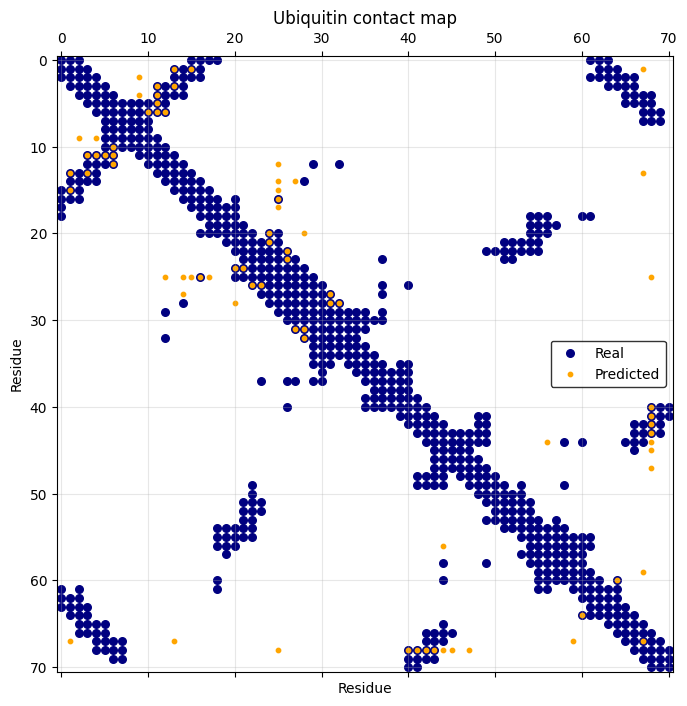

In conclusion, in this exercise, I showed how small protein language models like TapeBERT and ESM-2 8M can assist in the exploration of protein structure and function. These PLMs are able to detect functional residues as well as residues in contact in the 3D structure, even if they are far apart in the sequence.

# Code

## TapeBERT

In [1]:
import io
import urllib

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from Bio.Data import SCOPData
from Bio.PDB import Structure, PDBParser, PPBuilder
from tape import TAPETokenizer, ProteinBertModel
import nglview

In [2]:
# model config  
tokenizer = TAPETokenizer()
model = ProteinBertModel.from_pretrained('bert-base', output_attentions=True)


def get_chain(pdb_id, chain_id='A'):
    """
    Download a pdb file and select the chain A
    """
    # Download and parsing
    resource = urllib.request.urlopen(f'https://files.rcsb.org/download/{pdb_id}.pdb')
    content = resource.read().decode('utf8')
    handle = io.StringIO(content)
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, handle)
    
    # select chain A coords
    filtered_structure = []
    for model in structure:
        for chain in model:
            if chain.id == chain_id:
                filtered_structure.append(chain)
    
    # create a new pdb
    filtered_structure = Structure.Structure(pdb_id)
    for model in structure:
        filtered_model = model.__class__(model.get_id())  
        for chain in model:
            if chain.id == chain_id:
                filtered_model.add(chain)  
        filtered_structure.add(filtered_model)
    
    return filtered_structure
    

def get_attn_data(chain, layer, head, min_attn, start_index=0, end_index=None, max_seq_len=1024):
    
    """
    compute attention betweins pairs of residues given a head and layer
    """
    
    tokens = []
    coords = []
    residues = []  
    
    # get CA atom coords
    for res in chain:
        t = SCOPData.protein_letters_3to1.get(res.get_resname(), "X")  
        tokens.append(t)
        residues.append(res)  
        if t == 'X':  
            coord = None
        else:
            coord = res['CA'].coord.tolist() if 'CA' in res else None  
        coords.append(coord)

    # cut the seq if unnatural aa exist
    last_non_x = None
    for i in reversed(range(len(tokens))):
        if tokens[i] != 'X':
            last_non_x = i
            break
    assert last_non_x is not None
    tokens = tokens[:last_non_x + 1]
    coords = coords[:last_non_x + 1]
    residues = residues[:last_non_x + 1]

    # tokenization
    if max_seq_len:
        tokens = tokens[:max_seq_len - 2]  
        residues = residues[:max_seq_len - 2]
    token_idxs = tokenizer.encode(tokens).tolist()
    if max_seq_len:
        assert len(token_idxs) == min(len(tokens) + 2, max_seq_len)
    else:
        assert len(token_idxs) == len(tokens) + 2

    # get attentions values 
    inputs = torch.tensor(token_idxs).unsqueeze(0)
    with torch.no_grad():
        attns = model(inputs)[-1]
    attns = [attn[:, :, 1:-1, 1:-1] for attn in attns]  
    attns = torch.stack([attn.squeeze(0) for attn in attns])
    attn = attns[layer, head]
    if end_index is None:
        end_index = len(tokens)

    # parsing data and get resid positions
    attn_data = []
    for i in range(start_index, end_index):
        for j in range(i, end_index):
            a = max(attn[i, j].item(), attn[j, i].item())
            if a is not None and a >= min_attn:
                residue_from = f"{residues[i].get_resname()}-{residues[i].id[1]}"
                residue_to = f"{residues[j].get_resname()}-{residues[j].id[1]}"
                attn_data.append((a, coords[i], coords[j], residue_from, residue_to))

    # logs
    layer = layer + 1
    head = head + 1
    if len(attn_data) == 0:
        print(f"{layer=} and {head=} | Number of detected pairs: 0 (not detected)")
        attn_data = [(0, None, None, None, None)]  
    else:
        print(f"{layer=} and {head=} | Number of detected pairs: {len(attn_data)}")

    return attn_data    

/home/gama/anaconda3/envs/provis/lib/python3.8/site-packages/tape/models/modeling_utils.py:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolve

In [3]:
pdb_id = "1YIW"
chain_id = "A" # None = All chains
structure = get_chain(pdb_id)

models = list(structure.get_models())
prot_model = models[0]
chain = prot_model[chain_id]

min_attn = 0.3
num_layers = 12
num_heads = 12

# empty mattrix
attention_matrix = torch.zeros(num_layers, num_heads) 

# get avg attn
for layer in range(num_layers):    
    for head in range(num_heads):
        attn_data = get_attn_data(chain, layer, head, min_attn)
        attention_values = [att for att, _, _, _, _ in attn_data]
        if attention_values:  
            avg_attention = sum(attention_values) / len(attention_values)  # mean
            attention_matrix[layer, head] = avg_attention
        else:
            attention_matrix[layer, head] = 0 

layer=1 and head=1 | Number of detected pairs: 0 (not detected)
layer=1 and head=2 | Number of detected pairs: 30
layer=1 and head=3 | Number of detected pairs: 30
layer=1 and head=4 | Number of detected pairs: 0 (not detected)
layer=1 and head=5 | Number of detected pairs: 54
layer=1 and head=6 | Number of detected pairs: 11
layer=1 and head=7 | Number of detected pairs: 7
layer=1 and head=8 | Number of detected pairs: 8
layer=1 and head=9 | Number of detected pairs: 15
layer=1 and head=10 | Number of detected pairs: 23
layer=1 and head=11 | Number of detected pairs: 7
layer=1 and head=12 | Number of detected pairs: 8
layer=2 and head=1 | Number of detected pairs: 1
layer=2 and head=2 | Number of detected pairs: 31
layer=2 and head=3 | Number of detected pairs: 10
layer=2 and head=4 | Number of detected pairs: 0 (not detected)
layer=2 and head=5 | Number of detected pairs: 2
layer=2 and head=6 | Number of detected pairs: 22
layer=2 and head=7 | Number of detected pairs: 9
layer=2 and 

In [4]:
heads = [f"H{i}" for i in range(1, 13)] 
df_attn = pd.DataFrame(attention_matrix, columns=heads)
df_attn

,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0.000000,0.580405,0.413823,0.000000,0.678946,0.729433,0.402043,0.355801,0.598749,0.369254,0.349661,0.530676
1,0.311122,0.577395,0.359901,0.000000,0.327127,0.398239,0.507060,0.451321,0.467745,0.484655,0.415928,0.000000
2,0.433187,0.305231,0.000000,0.670910,0.374836,0.000000,0.325206,0.302042,0.000000,0.000000,0.321367,0.338938
3,0.362500,0.457955,0.476981,0.370631,0.455349,0.793927,0.316644,0.382613,0.000000,0.396143,0.310170,0.352788
4,0.322379,0.313440,0.404626,0.329483,0.331987,0.396133,0.315735,0.411467,0.997506,0.803025,0.000000,0.357552
5,0.999238,0.981776,0.999742,0.830842,0.996522,0.987794,0.449272,0.951914,0.986294,0.000000,0.000000,0.996909
6,0.000000,0.318396,0.434876,0.972550,0.361088,0.000000,0.321625,0.560664,0.427868,0.582026,0.837192,0.860716
7,0.654601,0.381184,0.368300,0.000000,0.403428,0.000000,0.315176,0.417535,0.340677,0.428838,0.000000,0.000000
8,0.000000,0.361484,0.000000,0.000000,0.000000,0.333331,0.000000,0.317673,0.000000,0.000000,0.324473,0.000000
9,0.402397,0.358834,0.000000,0.000000,0.000000,0.383625,0.000000,0.327119,0.000000,0.000000,0.000000,0.000000


In [5]:
layers = [f"L{i}" for i in range(1, 13)] 
df_max = df_attn.mean(axis=1)

df_layers = pd.DataFrame({'attn': df_max.values, 'layers': layers})
df_layers['attn'] = df_layers['attn'].round(2)

df_layers

,attn,layers
0,0.42,L1
1,0.36,L2
2,0.26,L3
3,0.39,L4
4,0.42,L5
5,0.77,L6
6,0.47,L7
7,0.28,L8
8,0.11,L9
9,0.12,L10


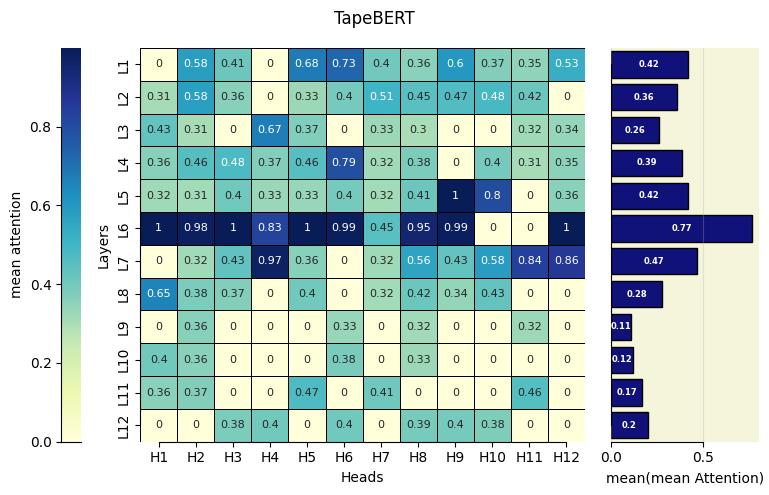

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5), gridspec_kw={"width_ratios": [4, 1]})

# heatmap 
sns.heatmap(df_attn, cmap="YlGnBu", linewidth=0.5, 
            cbar_kws={"label": "mean attention", "location": "left"}, 
            annot=True, annot_kws={"fontsize":8},
            linecolor='black', ax=ax[0])
ax[0].set_xlabel("Heads")
ax[0].set_ylabel("Layers")
ax[0].set_yticklabels(layers)

# barplot
sns.barplot(df_layers, y="layers", x="attn", color="darkblue", ax=ax[1], edgecolor="k")
sns.despine(trim=True)
ax[1].set_xlabel("mean(mean Attention)")
ax[1].grid("--", alpha=0.3)
ax[1].set_ylabel("")
ax[1].set_yticks([])
ax[1].set_facecolor("beige")
ax[1].bar_label(ax[1].containers[0], size=6, label_type="center", color="w", weight="bold")

plt.suptitle("TapeBERT")
plt.tight_layout()
plt.show()

In [7]:
# viz settings
layer = 6
head = 12
chain_ids = "A"
layer_zero_indexed = layer - 1
head_zero_indexed = head - 1
attn_color = [0,250,0] # https://www.rapidtables.com/web/color/RGB_Color.html
attn_scale = 0.2

view = nglview.show_biopython(structure)
view.stage.set_parameters(**{
    "backgroundColor": "black",
    "fogNear": 50, "fogFar": 100,
})

# plot the attention pairs on the protein
if len(models) > 1:
    print('Warning:', len(models), 'models. Using first one')

if chain_ids is None:
    chain_ids = [chain.id for chain in prot_model]
for chain_id in chain_ids: 
    chain = prot_model[chain_id]    
    attn_data = get_attn_data(chain, layer_zero_indexed, head_zero_indexed, min_attn)
    for att, coords_from, coords_to, residue_from, residue_to in attn_data:
        view.shape.add_cylinder(coords_from, coords_to, attn_color, att * attn_scale)         
view

layer=6 and head=12 | Number of detected pairs: 69


NGLWidget()

In [8]:
cols = ["attn","coords_from", "coords_to", "aa_from", "aa_to"]

df_lh = pd.DataFrame(attn_data, columns=cols)
df_lh = df_lh.sort_values("attn", ascending=False).reset_index(drop=True)
print(f"mean attn: {np.mean(df_lh.attn)}")
df_lh

mean attn: 0.9969089134879734


,attn,coords_from,coords_to,aa_from,aa_to
0,0.999970,"[29.445999145507812, 4.168000221252441, 6.2550...","[33.257999420166016, 4.710999965667725, 2.5239...",ILE-23,ASN-25
1,0.999969,"[37.43899917602539, -7.706999778747559, 5.7459...","[32.391998291015625, -4.857999801635742, 3.204...",ILE-36,PRO-38
2,0.999959,"[32.61899948120117, -1.6100000143051147, 16.67...","[29.843000411987305, -6.945000171661377, 15.19...",HIS-68,VAL-70
3,0.999949,"[34.6619987487793, 8.145000457763672, 18.46800...","[32.882999420166016, 2.1389999389648438, 16.18...",SER-65,LEU-67
4,0.999940,"[27.033000946044922, 9.472000122070312, 6.9019...","[27.53700065612793, 13.105999946594238, 10.854...",THR-55,SER-57
...,...,...,...,...,...
64,0.990086,"[39.03300094604492, -9.588000297546387, 18.226...","[42.13100051879883, -5.01800012588501, 17.4270...",THR-9,LYS-11
65,0.987955,"[33.76100158691406, -0.020999999716877937, 5.125]","[38.78099822998047, 1.8589999675750732, 4.4699...",LYS-27,LYS-29
66,0.986796,"[42.61600112915039, 3.99399995803833, 13.22200...","[41.00400161743164, 9.291000366210938, 8.85999...",THR-14,GLU-16
67,0.980386,"[41.00400161743164, 9.291000366210938, 8.85999...","[35.53300094604492, 13.479000091552734, 6.7839...",GLU-16,GLU-18


## ESM-2 8M

In [9]:
import esm

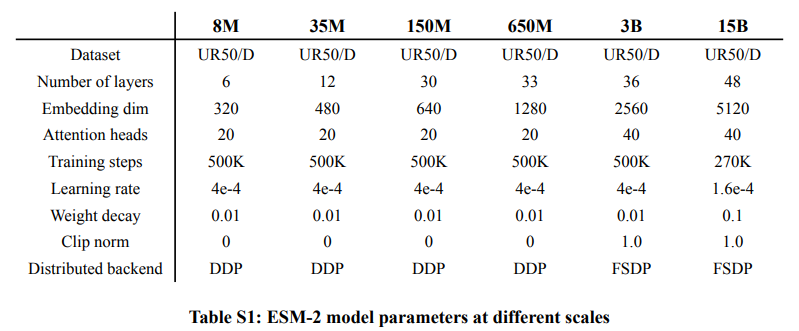

In [10]:
# model set-up
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
seq = "LQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVL" # the last 5 aa (RLRGG) are only present in chain C
print(f"number of layers: {model.num_layers}")
data = [("ubiquitin", seq)]  
batch_labels, batch_strs, batch_tokens = batch_converter(data)  

number of layers: 6


In [11]:
# get the embeddings and attentions
model.eval()
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=True) # 6 layers for the 8M model
attentions = results["attentions"] # shape: (num_seqs, num_layers, num_heads, seq_len, seq_len) <BOS> seq_len <EOS>

# mean attn without bos and eos
attentions_avg = attentions[:, :, :, 1:-1, 1:-1].mean(dim=(0, 3, 4))

In [12]:
cols = [f"H{i}" for i in range(1, 21)] 
df_esm = pd.DataFrame(attentions_avg.numpy(), columns=cols)

# min-max norm
df_esm_norm = (df_esm - df_esm.min()) / (df_esm.max() - df_esm.min()) 
df_esm_norm

,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20
0,0.304832,0.743648,0.000000,0.165611,0.444782,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.670100,0.000000,1.000000,0.000000,0.000000,0.000000,0.917395,0.348494,0.316366
1,0.714773,0.937180,0.201372,0.732611,0.871048,0.301261,0.207036,1.000000,0.000000,0.836579,0.928876,1.000000,0.914603,0.000000,1.000000,0.757666,0.349039,0.498371,0.435275,0.776122
2,0.448954,1.000000,0.764661,0.998429,0.000000,0.454421,0.304022,0.344656,0.869379,0.766895,0.466879,0.000000,0.405321,0.895785,0.837326,1.000000,1.000000,0.000000,0.952413,0.522809
3,1.000000,0.378298,0.367235,0.892704,0.849055,0.738654,0.903282,0.820170,0.666200,0.004799,0.822938,0.799399,0.908132,0.974158,0.794693,0.475247,0.165810,0.612476,0.978908,0.876702
4,0.000000,0.000000,0.853530,0.000000,1.000000,1.000000,0.890517,0.555573,0.250330,1.000000,0.962395,0.150957,0.621197,0.985395,0.894865,0.342457,0.652254,1.000000,1.000000,1.000000
5,0.970773,0.410307,1.000000,1.000000,0.603917,0.898255,1.000000,0.538476,0.549437,0.903752,1.000000,0.718176,1.000000,0.767349,0.842954,0.475267,0.882633,0.806033,0.000000,0.000000


In [13]:
# minn attn theshold
df_esm_norm[df_esm_norm < 0.3] = 0
df_esm_norm

,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20
0,0.304832,0.743648,0.000000,0.000000,0.444782,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.670100,0.000000,1.000000,0.000000,0.000000,0.000000,0.917395,0.348494,0.316366
1,0.714773,0.937180,0.000000,0.732611,0.871048,0.301261,0.000000,1.000000,0.000000,0.836579,0.928876,1.000000,0.914603,0.000000,1.000000,0.757666,0.349039,0.498371,0.435275,0.776122
2,0.448954,1.000000,0.764661,0.998429,0.000000,0.454421,0.304022,0.344656,0.869379,0.766895,0.466879,0.000000,0.405321,0.895785,0.837326,1.000000,1.000000,0.000000,0.952413,0.522809
3,1.000000,0.378298,0.367235,0.892704,0.849055,0.738654,0.903282,0.820170,0.666200,0.000000,0.822938,0.799399,0.908132,0.974158,0.794693,0.475247,0.000000,0.612476,0.978908,0.876702
4,0.000000,0.000000,0.853530,0.000000,1.000000,1.000000,0.890517,0.555573,0.000000,1.000000,0.962395,0.000000,0.621197,0.985395,0.894865,0.342457,0.652254,1.000000,1.000000,1.000000
5,0.970773,0.410307,1.000000,1.000000,0.603917,0.898255,1.000000,0.538476,0.549437,0.903752,1.000000,0.718176,1.000000,0.767349,0.842954,0.475267,0.882633,0.806033,0.000000,0.000000


In [14]:
layers = [f"L{i}" for i in range(1, 7)]
esm_layers = df_esm_norm.mean(axis=1)

df_esm_layers = pd.DataFrame({'attn': esm_layers.values, 'layers': layers})
df_esm_layers['attn'] = df_esm_layers['attn'].round(2)

df_esm_layers.sort_values("attn")

,attn,layers
0,0.29,L1
1,0.60,L2
2,0.60,L3
4,0.64,L5
3,0.69,L4
5,0.72,L6


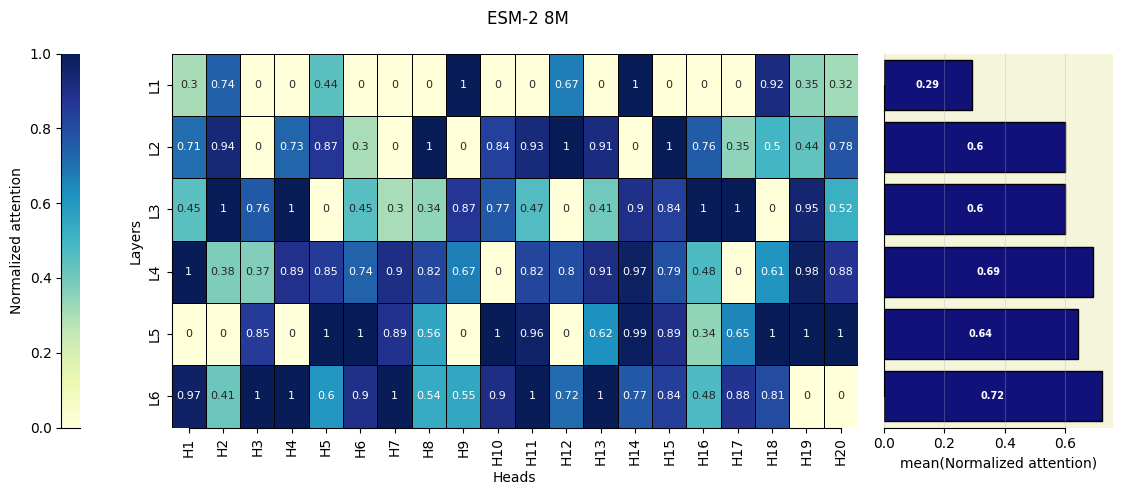

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [4, 1]})

# heatmap 
sns.heatmap(df_esm_norm, cmap="YlGnBu", linewidth=0.5, 
            cbar_kws={"label": "Normalized attention", "location": "left"}, 
            annot=True, annot_kws={"fontsize":8},
            linecolor='black', ax=ax[0])
ax[0].set_xlabel("Heads")
ax[0].set_ylabel("Layers")
ax[0].set_yticklabels(layers)

# barplot
sns.barplot(df_esm_layers, y="layers", x="attn", color="darkblue", ax=ax[1], edgecolor="k")
sns.despine(trim=True)
ax[1].set_xlabel("mean(Normalized attention)")
ax[1].grid("--", alpha=0.3)
ax[1].set_ylabel("")
ax[1].set_yticks([])
ax[1].set_facecolor("beige")
ax[1].bar_label(ax[1].containers[0], size=7, label_type="center", color="w", weight="bold")

plt.suptitle("ESM-2 8M")
plt.tight_layout()
plt.show()

In [16]:
from graphein.protein.graphs import construct_graph
from graphein.protein.config import ProteinGraphConfig

Output()

Text(0.5, 1.0, 'True contact map')

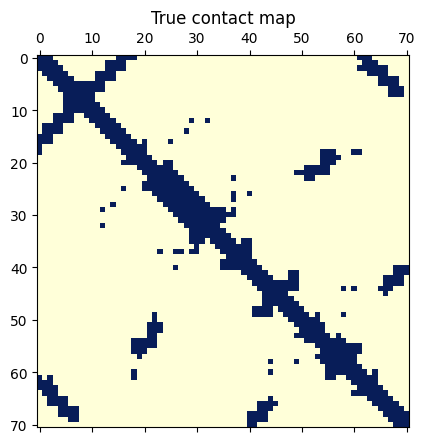

In [108]:
# Create backbone graph
# https://graphein.ai/notebooks/interactive_plotly_example.html#Distance-Matrix-and-Contact-Map
# https://graphein.ai/modules/graphein.protein.html?highlight=proteingraphconfig#graphein.protein.config.ProteinGraphConfig
config = ProteinGraphConfig()
simple_graph = construct_graph(config, pdb_code="1YIW", chain_selection=["A"])

contact_map = (simple_graph.graph["dist_mat"] <= 8).astype(int) # Threshold distance matrix
plt.matshow(contact_map, cmap="YlGnBu")
plt.title("True contact map")

In [27]:
simple_graph.graph.keys()

dict_keys(['name', 'pdb_code', 'path', 'chain_ids', 'pdb_df', 'raw_pdb_df', 'rgroup_df', 'coords', 'node_type', 'sequence_A', 'config', 'dist_mat'])

In [28]:
simple_graph.graph["sequence_A"]

'LQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVL'

In [29]:
simple_graph.graph["raw_pdb_df"]

,record_name,atom_number,atom_name,alt_loc,residue_name,chain_id,residue_number,insertion,x_coord,y_coord,z_coord,occupancy,b_factor,element_symbol,charge,model_idx,node_id,residue_id
0,ATOM,1,N,,LEU,A,1,,39.002998,14.140000,10.446,1.0,16.440001,N,,1,A:LEU:1,A:LEU:1
1,ATOM,2,CA,,LEU,A,1,,38.308998,13.491000,11.575,1.0,15.560000,C,,1,A:LEU:1,A:LEU:1
2,ATOM,3,C,,LEU,A,1,,38.998001,12.156000,11.840,1.0,13.440000,C,,1,A:LEU:1,A:LEU:1
3,ATOM,4,O,,LEU,A,1,,39.144001,11.387000,10.916,1.0,12.370000,O,,1,A:LEU:1,A:LEU:1
4,ATOM,5,CB,,LEU,A,1,,36.845001,13.246000,11.162,1.0,18.049999,C,,1,A:LEU:1,A:LEU:1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,HETATM,1967,O,,HOH,C,1359,,26.021000,24.587999,13.517,0.5,28.330000,O,,1,C:HOH:1359,C:HOH:1359
1964,HETATM,1968,O,,HOH,C,1360,,19.990999,28.371000,6.469,0.5,18.629999,O,,1,C:HOH:1360,C:HOH:1360
1965,HETATM,1969,O,,HOH,C,1361,,20.396000,27.242001,9.300,0.5,25.549999,O,,1,C:HOH:1361,C:HOH:1361
1966,HETATM,1970,O,,HOH,C,1362,,26.653999,28.350000,18.434,0.5,29.809999,O,,1,C:HOH:1362,C:HOH:1362


In [30]:
data

[('ubiquitin',
  'LQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVL')]

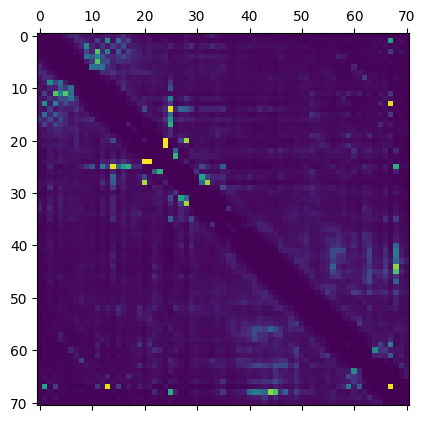

In [109]:
# https://github.com/facebookresearch/esm/discussions/72 
# https://github.com/facebookresearch/esm/issues/34

model.eval()
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

#  per-residue embeddings
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=True)
token_representations = results["representations"][6]

for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.show()

In [110]:
results['contacts'].shape

torch.Size([1, 71, 71])

Text(0.5, 1.0, 'Predicted contact map')

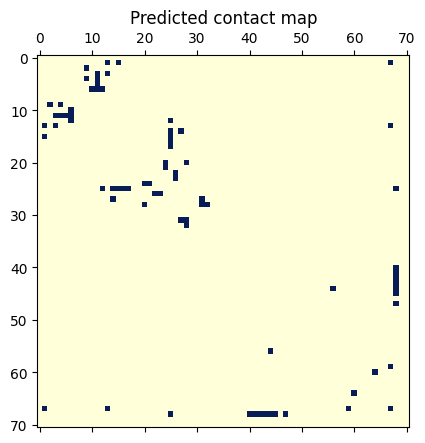

In [144]:
pred_contact_map = pd.DataFrame(attention_contacts)
df_bin_contacts = pred_contact_map.applymap(lambda x: 1 if x >= 0.3 else 0)
plt.matshow(df_bin_contacts, cmap="YlGnBu")
plt.title("Predicted contact map")

In [145]:
contact_map

,0,28,29,30,31,32,33,34,35,36,...,61,62,63,64,65,66,70,67,68,69
0,1,1,1,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
28,1,1,1,1,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
29,1,1,1,1,1,0,0,0,0,0,...,1,1,1,1,1,1,0,0,0,0
30,0,1,1,1,1,1,0,0,0,0,...,0,0,1,1,1,1,0,0,0,0
31,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0,0,1,1,1,1,0,0,0,0,...,0,0,0,1,1,1,1,1,0,0
70,0,0,0,0,1,1,1,1,0,0,...,0,0,0,0,1,1,1,1,1,0
67,0,0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,1,1,1,1,1
68,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,1,1,1


In [146]:
df_bin_contacts

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
68,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


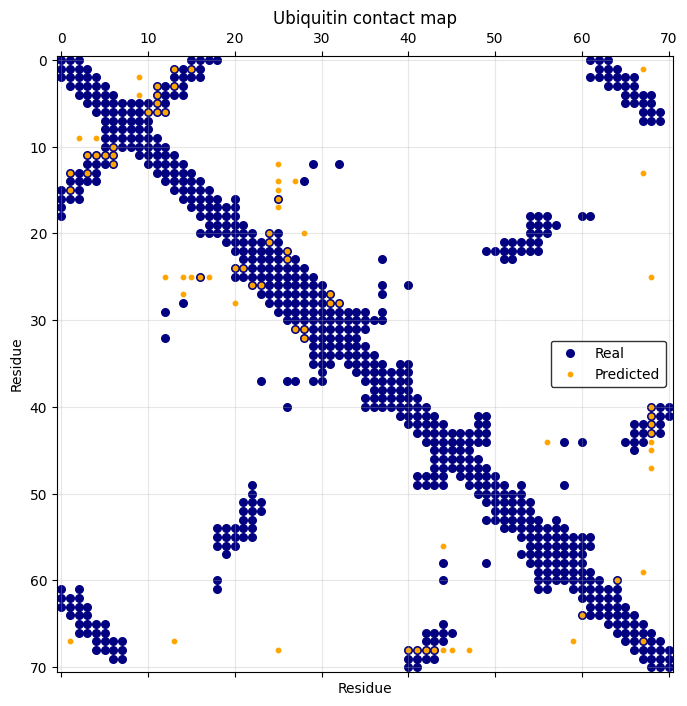

In [147]:
contact_map_np = contact_map.to_numpy()
df_bin_contacts_np = df_bin_contacts.to_numpy()

# plot
fig, ax = plt.subplots(figsize=(8, 8))

# empty mat
ax.matshow(np.zeros_like(contact_map), cmap='Greys', alpha=0)

# Real contacts
real_scatter = []
for (i, j), value in np.ndenumerate(contact_map):
    if value == 1:
        real_scatter.append(ax.scatter(j, i, color='navy', s=30, edgecolor=None))

# Predicted contacts
pred_scatter = []
for (i, j), value in np.ndenumerate(df_bin_contacts):
    if value == 1:
        pred_scatter.append(ax.scatter(j, i, color='orange', s=10, edgecolor=None))

# legend
handles = [real_scatter[0], pred_scatter[0]] 
labels = ['Real', 'Predicted']
ax.legend(handles=handles, labels=labels, edgecolor="black")

ax.set_title('Ubiquitin contact map')
ax.set_xlabel('Residue')
ax.set_ylabel('Residue')
ax.grid("--", alpha=0.3)

plt.show()

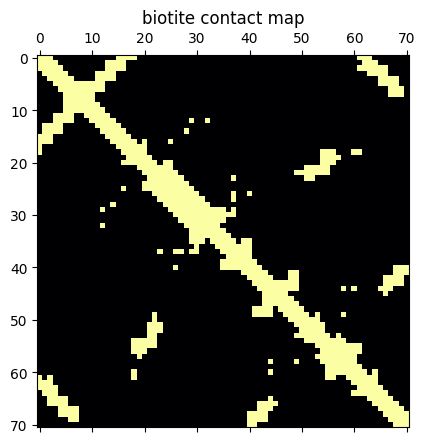

In [148]:
from tempfile import gettempdir
import biotite
import biotite.database.rcsb as rcsb
import biotite.structure as struc
import biotite.structure.io as strucio

file_name = rcsb.fetch("1YIW", "bcif", gettempdir())
array = strucio.load_structure(file_name)
chain_a = array[array.chain_id == "A"]
ca = chain_a[chain_a.atom_name == "CA"]

cell_list = struc.CellList(ca, cell_size=8) # angstrom theshold
adjacency_matrix = cell_list.create_adjacency_matrix(threshold)

plt.matshow(adjacency_matrix, cmap="inferno")
plt.title("biotite contact map")
plt.show()